In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import join
import regress
import h5py
import csv

In [2]:
BATCH_SIZE = 35
def gen_rand_noise(): # z
    noise = torch.randn(BATCH_SIZE, 127)
    return noise


In [3]:
gen = torch.load('output/JFDebugging/generator.pt', map_location='cpu') 
gen.eval()

regressor = regress.JF_Net()

regressor.load_state_dict(torch.load('JF_regressor.pt',map_location='cpu'))
regressor.eval()

params = sum(p.numel() for p in regressor.parameters() if p.requires_grad)
print('Num of params:'+ str(params))

Num of params:22197154


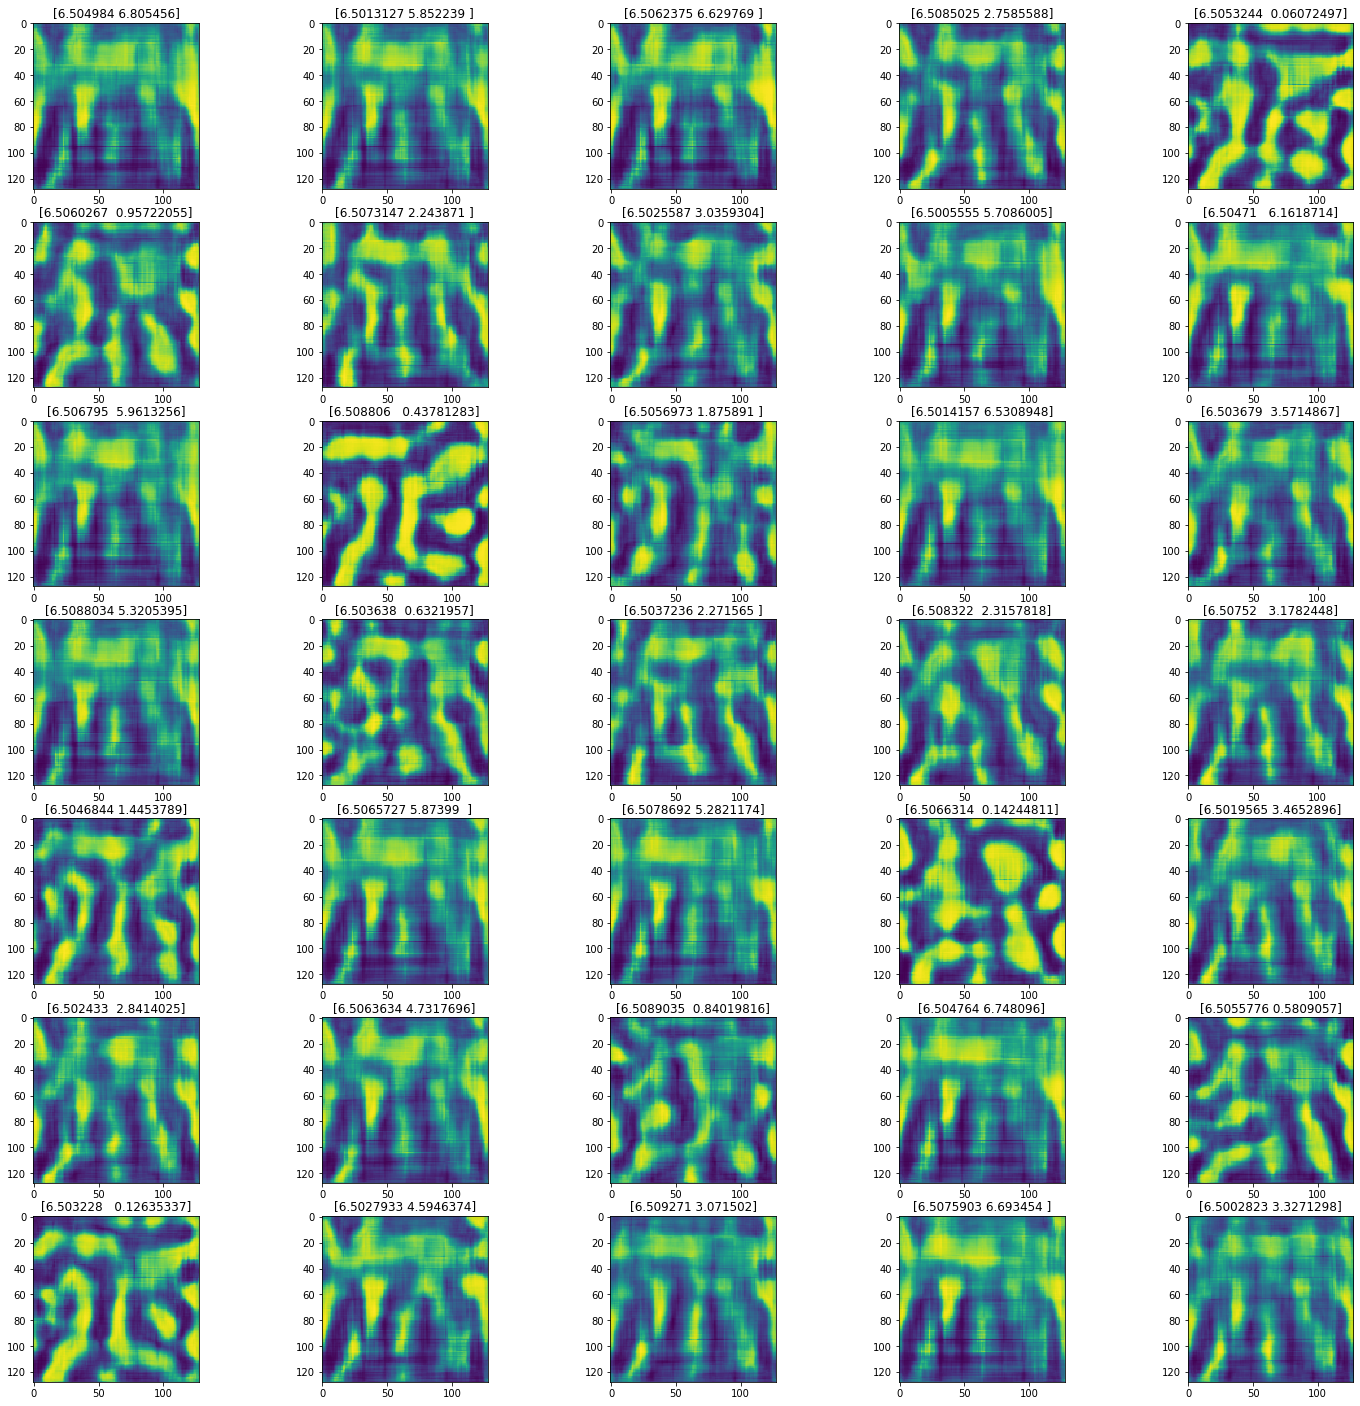

In [13]:
noise = gen_rand_noise()

ps = []
for i in range(7):
    for j in range(5):
        #J = np.random.uniform(low = 0.01+i, high = 1+i, size = 1)
        J = np.random.uniform(low = 6.5, high = 6.51, size = 1)
        #ff = np.random.uniform(low = 0.01+6-i, high = 1+6-i, size = 1)
        ff = np.random.uniform(low = 0.01, high = 6.9, size = 1)
        
        p = (J, ff)
        ps.append(p)

ps = np.asarray(ps)
#print(ps)

#ps = np.expand_dims(np.ndarray.flatten(np.sort(np.asarray(ps))), axis=1)
ps = np.squeeze(ps, axis=2)
ps = torch.FloatTensor(ps)
#print(ps.shape)

#Js = torch.FloatTensor([[0.01], [0.5], [3.0], [3.2], [6.3]])

gen_img = gen(noise, ps).detach().numpy()
fig, axs = plt.subplots(7, 5, figsize=(25,25))

i=0
j=0
for i in range(7):
    
    img = np.reshape(gen_img[0+j],(128,128))
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(ps[0+j].detach().numpy()))
    
    img = np.reshape(gen_img[1+j],(128,128))
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(str(ps[1+j].detach().numpy()))
    
    img = np.reshape(gen_img[2+j],(128,128))
    axs[i, 2].imshow(img)
    axs[i, 2].set_title(str(ps[2+j].detach().numpy()))
    
    img = np.reshape(gen_img[3+j],(128,128))
    axs[i, 3].imshow(img)
    axs[i, 3].set_title(str(ps[3+j].detach().numpy()))
    
    img = np.reshape(gen_img[4+j],(128,128))
    axs[i, 4].imshow(img)
    axs[i, 4].set_title(str(ps[4+j].detach().numpy()))
    
    j+=5
    
    #ax.title.set_title(str(Js[i].detach().numpy()))
    #ax.imshow(img)
    #plt.imsave('sample_'+ str(Js[i]) + '.png', img)
    #i+=1    
    

Text(0.5, 0, 'Design Input ff')

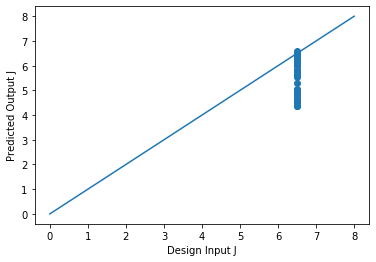

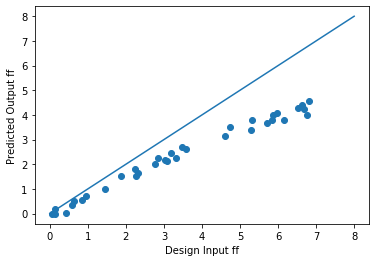

In [14]:
pred_ps = []
for i in range(35):
    gen_data = torch.FloatTensor(np.reshape(gen_img[i],(128,128)))
    gen_data = torch.unsqueeze(torch.unsqueeze(gen_data, dim=0), dim=0)
    pred_p = regressor(gen_data)
    pred_ps.append(pred_p.detach().numpy())

pred_ps = np.asarray(pred_ps)

out_J = pred_ps[:,0]
out_ff = pred_ps[:,1]

ctrl_J = ps[:,0].detach().numpy()
ctrl_ff = ps[:,1].detach().numpy()

x = np.linspace(0,8,100)
y = x
plt.scatter(ctrl_J, out_J)
plt.plot(x,y)
plt.ylabel('Predicted Output J')
plt.xlabel('Design Input J')

plt.figure()
plt.scatter(ctrl_ff, out_ff)
plt.plot(x,y)
plt.ylabel('Predicted Output ff')
plt.xlabel('Design Input ff')

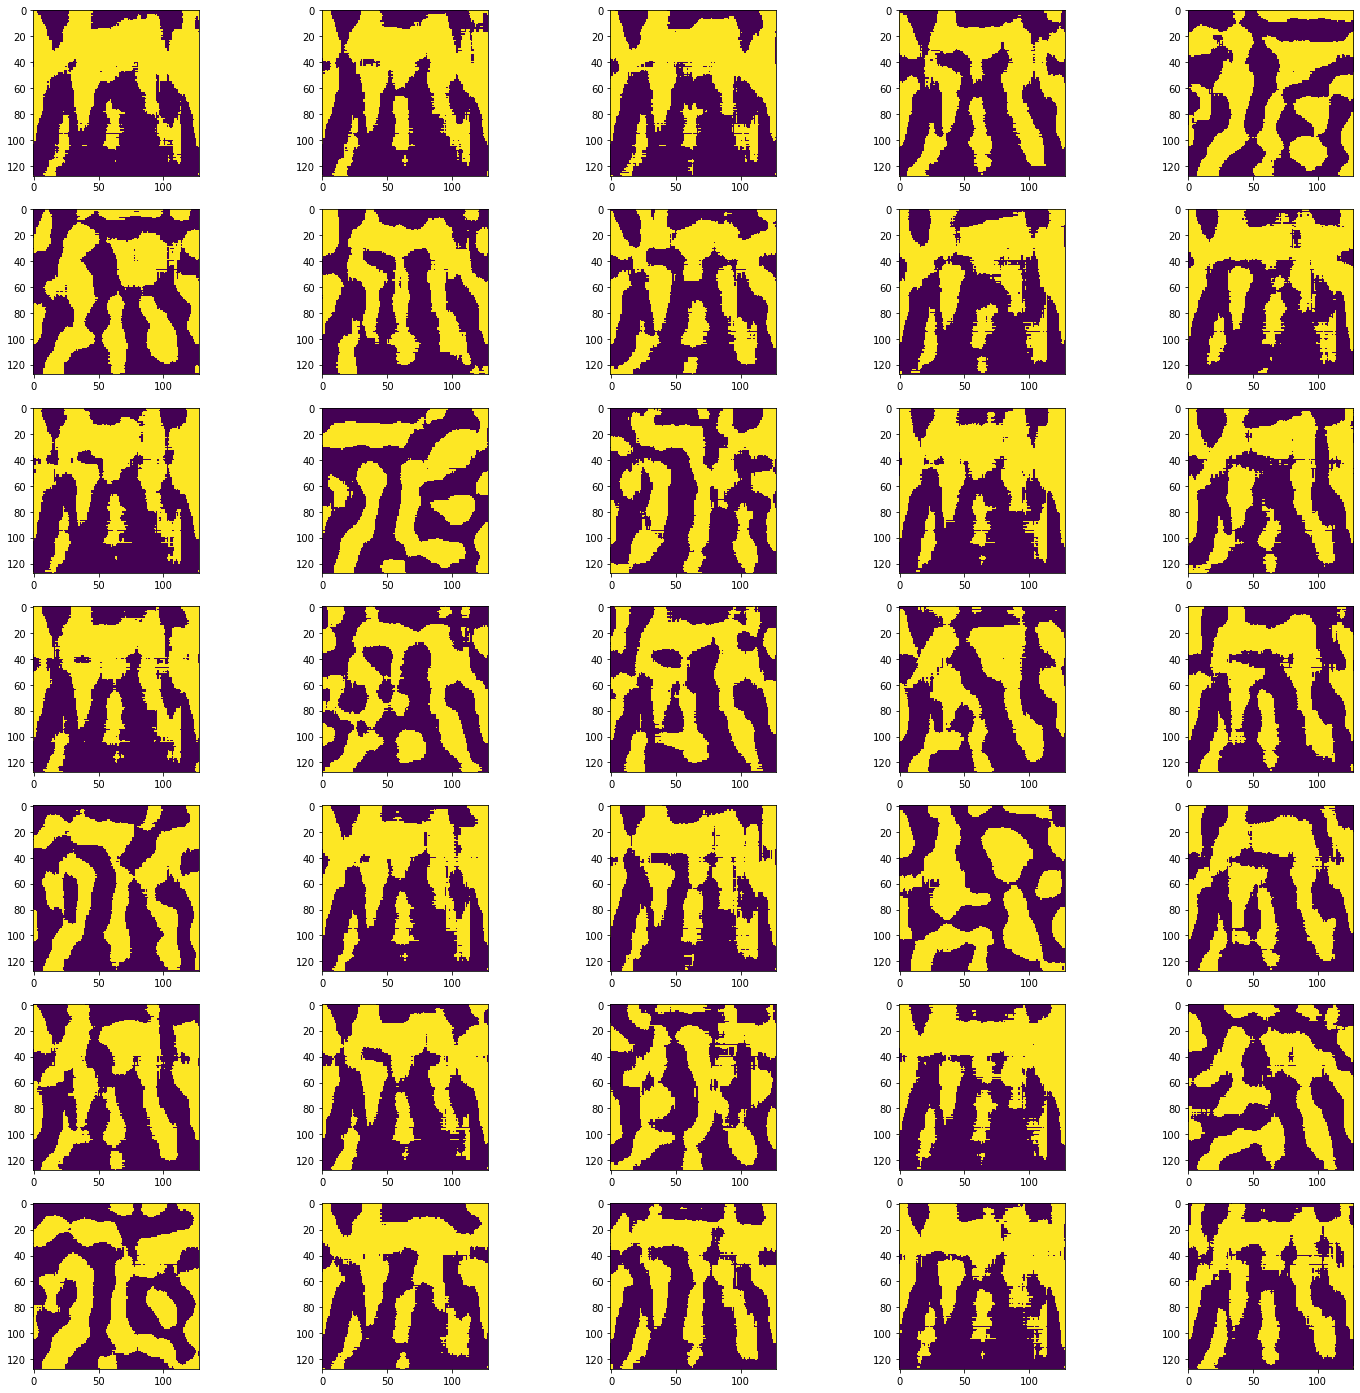

In [15]:
#binarized data for evaluation
bin_data = []
save_data = np.squeeze(gen_img, axis=1)
for i in range(save_data.shape[0]):
    
    avg = np.mean(save_data[i])
    #print(avg)
    bin_img = np.where(save_data[i] > avg, 1, 0)
    bin_data.append(bin_img)
    
bin_data = np.asarray(bin_data)

fig, axs = plt.subplots(7, 5, figsize=(25,25))

i=0
j=0
for i in range(7):
    
    axs[i, 0].imshow(bin_data[0+j])
    #axs[i, 0].set_title(str(ps[0+j].detach().numpy()))

    axs[i, 1].imshow(bin_data[1+j])
    #axs[i, 1].set_title(str(ps[1+j].detach().numpy()))
    
    axs[i, 2].imshow(bin_data[2+j])
    #axs[i, 2].set_title(str(ps[2+j].detach().numpy()))

    axs[i, 3].imshow(bin_data[3+j])
    #axs[i, 3].set_title(str(ps[3+j].detach().numpy()))

    axs[i, 4].imshow(bin_data[4+j])
    #axs[i, 4].set_title(str(ps[4+j].detach().numpy()))
    
    j+=5
    

# with h5py.File('test.h5', 'w') as hf:
#     hf.create_dataset("test",  data=gen_img[0][0])
# h5_data = np.squeeze(gen_img, axis=1)
# print(h5_data.shape)
# for i in range(35):
#     with h5py.File('test_' + str(i) + '.h5', 'w') as hf:
#         hf.create_dataset("test" + str(i),  data=h5_data[i])


In [10]:
flip_data = []
for i in range(bin_data.shape[0]):
    flip = np.flip(bin_data[i], axis=0)
#     flip = np.flip(flip, axis=1)
    flip_data.append(flip)

bin_data = np.asarray(flip_data)

for num in range(35):
    f= open(str(num) + "_2_test.plt","w+")
    f.write('TITLE ="t=0.000000"\n')
    f.write('VARIABLES = "x"  "y"      "MS"\n')
    f.write('ZONE N=16384, E=16129, F=FEPOINT, ET=QUADRILATERAL\n')
    a = 0
    for i in np.arange(0,128,1):
        b = 0
        for j in np.arange(0,128,1):
            f.write(str(j) + '.000000 ')
            f.write(str(i) + '.000000 ')
            morph = bin_data[num][a][b]
            #print(morph)
            f.write(str(morph) + '\n')
            b += 1
        a += 1
    for i in range(1, 16384-128+1):
        if i%128 == 0:
            continue
        f.write(str(i) + ' ')
        f.write(str(i+1) + ' ')
        f.write(str(i+129) + ' ')
        f.write(str(i+128) + ' \n')
    f.close() 

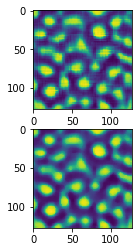

In [9]:
#median filter 
import scipy as sp
from scipy import ndimage

fig, axs = plt.subplots(2, 1)

img = np.reshape(gen_img[34],(128,128))
axs[0].imshow(img)
new_img = ndimage.median_filter(img, 5)
axs[1].imshow(new_img)

torch.Size([100, 1])


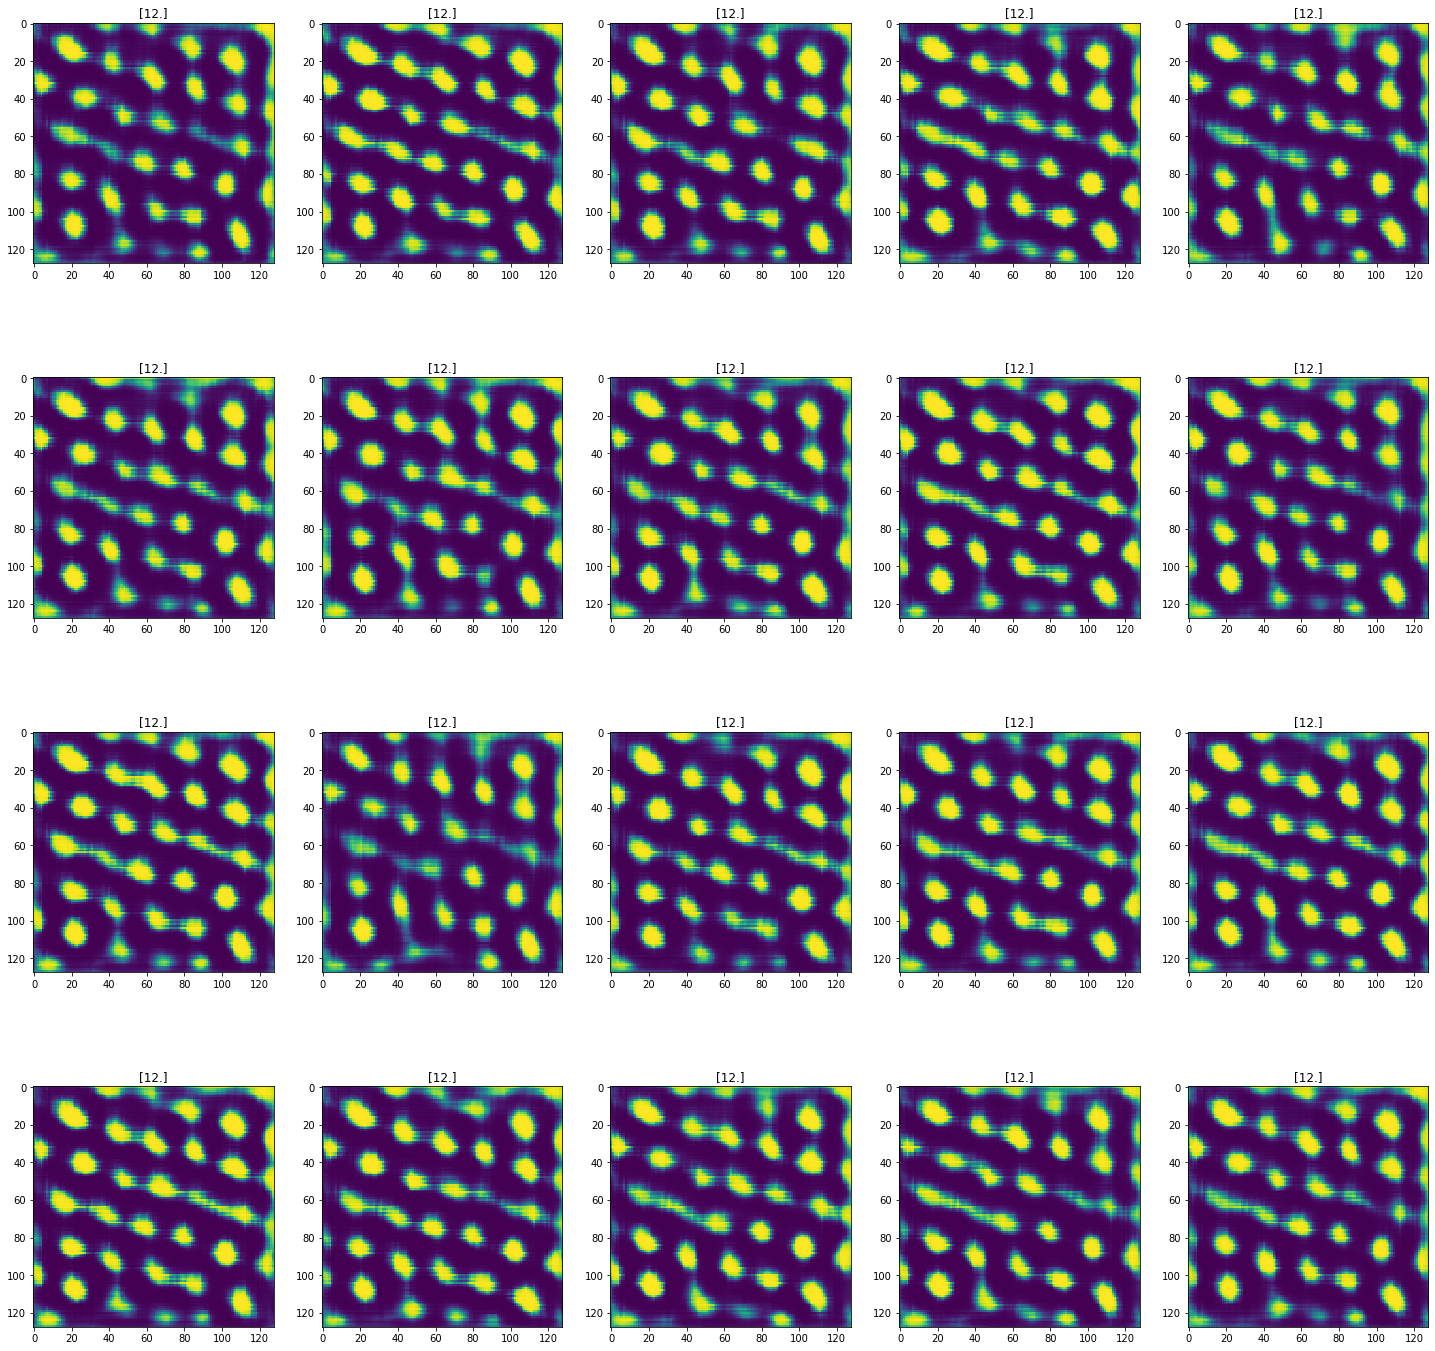

In [24]:
#generate within bounded range 20 sample and check distribution

BATCH_SIZE = 100
noise = gen_rand_noise()
low = 6
high  = 7
Js = []
#J = np.random.uniform(low = low, high = high, size = BATCH_SIZE)
J = np.ones(shape=BATCH_SIZE)*12
Js.append(J)

Js = np.expand_dims(np.ndarray.flatten(np.asarray(Js)), axis=1)
Js = torch.FloatTensor(Js)
print(Js.shape)

gen_img = gen(noise, Js).detach().numpy()

fig, axs = plt.subplots(4, 5, figsize=(25,25))
i=0
j=0
for i in range(4):
    img = np.reshape(gen_img[0+j],(128,128))
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(Js[0+j].detach().numpy()))
    
    img = np.reshape(gen_img[1+j],(128,128))
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(str(Js[1+j].detach().numpy()))
    
    img = np.reshape(gen_img[2+j],(128,128))
    axs[i, 2].imshow(img)
    axs[i, 2].set_title(str(Js[2+j].detach().numpy()))
    
    img = np.reshape(gen_img[3+j],(128,128))
    axs[i, 3].imshow(img)
    axs[i, 3].set_title(str(Js[3+j].detach().numpy()))
    
    img = np.reshape(gen_img[4+j],(128,128))
    axs[i, 4].imshow(img)
    axs[i, 4].set_title(str(Js[4+j].detach().numpy()))
    
    j+=5
    
pred_Js = []
for i in range(BATCH_SIZE):
    gen_data = torch.FloatTensor(np.reshape(gen_img[i],(128,128)))
    gen_data = torch.unsqueeze(torch.unsqueeze(gen_data, dim=0), dim=0)
    pred_J = regressor(gen_data)
    pred_Js.append(pred_J.detach().numpy())

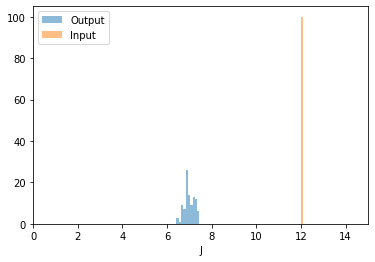

100.0
100.0


In [27]:
#plot densities of control vs predicted
ctrl_J = np.squeeze(Js.detach().numpy(), axis=1).tolist()
counts1, bins1, bars1 = plt.hist(pred_Js, alpha=0.5, density=False, label='Output')
counts2, bins2, bars2 = plt.hist(ctrl_J, alpha=0.5, density=False, label='Input')
#plt.ylabel('Count')
plt.xlabel('J')
plt.xlim(0,15)
plt.legend()
plt.show()

print(sum(counts1))
print(sum(counts2))

In [28]:
#load data and plot distribution of J and ff and pixel values
ds = np.load('/data/Bernard/DARPA_data/pytorch_normJF_data_train.npy', allow_pickle=True)

(128, 128)


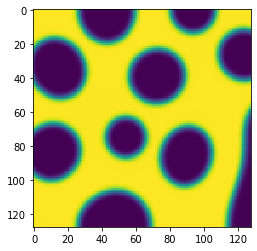

In [29]:
J_scale = 20.855220777251184
min_ff = 0.400146484375
data = ds[:,0]
J = ds[:,1]
ff_norm = ds[:,2]
ff_raw = list(np.asarray(ff_norm)/J_scale + min_ff)

print(data[0].shape) # 128, 128
plt.imshow(data[1])

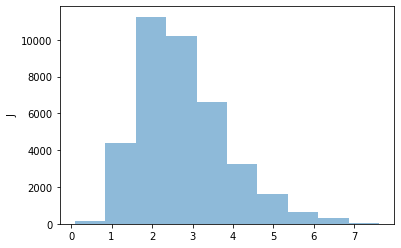

[  145.  4394. 11258. 10218.  6641.  3258.  1635.   648.   315.    67.]
[0.091497 0.8435272999999999 1.5955575999999998 2.3475878999999997
 3.0996181999999997 3.8516484999999996 4.6036788 5.3557091 6.1077394
 6.859769699999999 7.6118]


In [30]:
#plot densities of real data label
counts, bins, bars = plt.hist(J, alpha=0.5)
plt.ylabel('J')
plt.show()

print(counts)
print(bins)

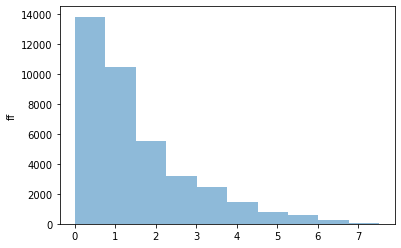

[13820. 10484.  5555.  3215.  2426.  1432.   763.   564.   276.    44.]
[0.0 0.7520302999999999 1.5040605999999999 2.2560909 3.0081211999999997
 3.7601514999999996 4.5121818 5.2642121 6.016242399999999
 6.768272699999999 7.520302999999999]


In [31]:
#plot densities of real data label
counts, bins, bars = plt.hist(ff_norm, alpha=0.5)
plt.ylabel('ff')
plt.show()

print(counts)
print(bins)

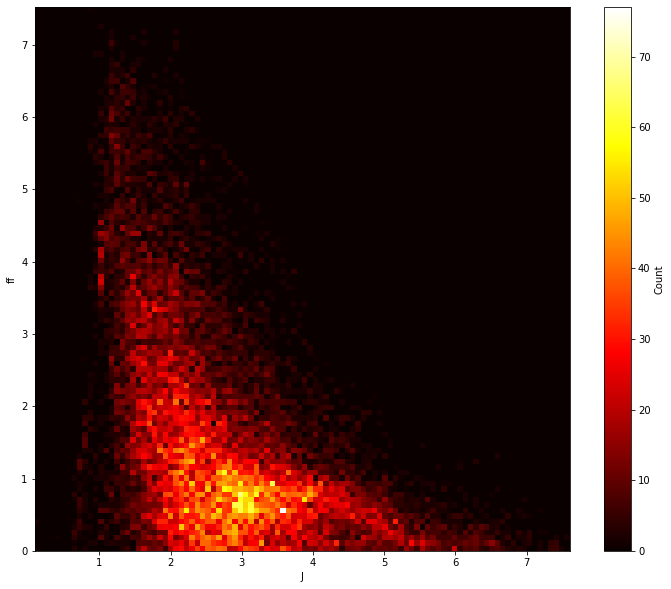

In [33]:
plt.figure(figsize = (12,10))
plt.hist2d(J, ff_norm, bins=100, cmap='hot', density=False)
plt.colorbar().set_label('Count')
plt.ylabel('ff')
plt.xlabel('J')
plt.show()

(74058, 3)


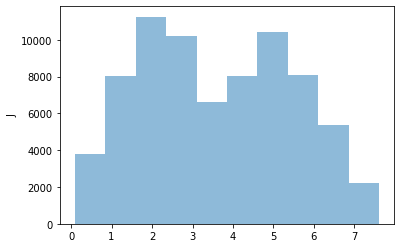

In [39]:
#code block to rebalance dataset with duplicate data
new_ds = ds
idx = np.where(ds[:,1]<1)
for i in range(25):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>4)
for i in range(2):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>5)
for i in range(9):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>6)
for i in range(5):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)
        
idx = np.where(ds[:,1]>7)
for i in range(25):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)
    
print(new_ds.shape)
label = new_ds[:,1]
#plot densities of real data label
counts, bins, bars = plt.hist(label, alpha=0.5)
plt.ylabel('J')
plt.show()

#np.save('/data/Bernard/DARPA_data/pytorch_balanced_fixed_flip_data_train.npy', new_ds)

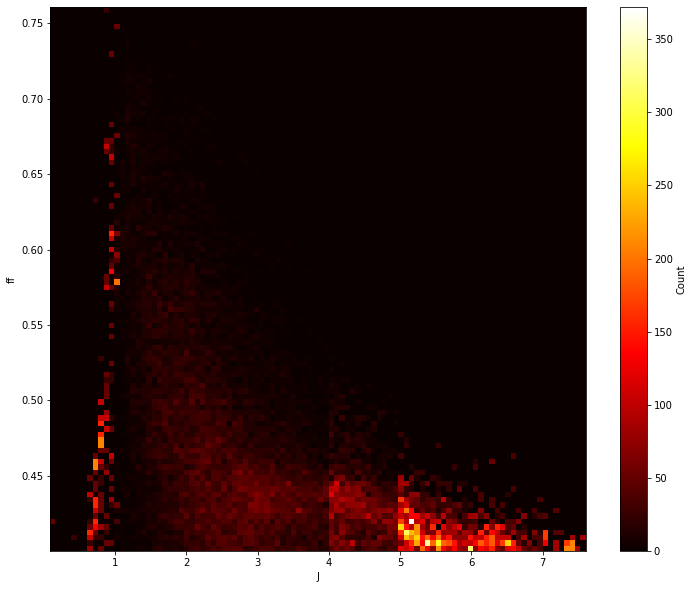

In [46]:
J = new_ds[:,1]
ff_norm = new_ds[:,2]
ff_raw = list(np.asarray(ff_norm)/J_scale + min_ff)
plt.figure(figsize = (12,10))
plt.hist2d(J, ff_raw, bins=100, cmap='hot', density=False)
plt.colorbar().set_label('Count')
plt.ylabel('ff')
plt.xlabel('J')
plt.show()